## Traininig the High Level Feature classifier with TensorFlow/Keras using data in TFRecord format

**4.0 Tensorflow/Keras and Petastorm, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. Data is read using TensorFlow from files in TFRecord format.

The High-Level Features classifier is built with labeled data
 - input: 14 features, described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
 - output: 3 classes, "W + jet", "QCD", "t tbar", see also [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
 - Open dataset: [download data](https://github.com/cerndb/SparkDLTrigger/tree/master/Data)
![Physics use case for the particle classifier](../Docs/Physics_use_case.png)

To run this notebook we used the following configuration:
* *Software stack*: TensorFlow 2.11.0
* *Platform*: CentOS 7, Python 3.9

## Create the Keras model

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [3]:
tf.version.VERSION

'2.11.0'

In [4]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

keras_model = create_model(50,20,10)

2023-03-13 11:50:16.092677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 11:50:16.639877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3323 MB memory:  -> device: 0, name: Quadro K2200, pci bus id: 0000:02:00.0, compute capability: 5.0


In [6]:
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                750       
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 2,013
Trainable params: 2,013
Non-trainable params: 0
_________________________________________________________________


## Load data and train the Keras model

In [7]:
# Download the datasets from 
# ** https://github.com/cerndb/SparkDLTrigger/tree/master/Data **
#
# For CERN users, data is already available on EOS
PATH = "/eos/project/s/sparkdltrigger/public/"

# PATH = "../Data/sparkdltrigger.web.cern.ch/sparkdltrigger/"

folder = PATH + "testUndersampled_HLF_features.tfrecord"

files_test_dataset = tf.data.Dataset.list_files(folder + "/part-r*", shuffle=False)

# training dataset 
folder = PATH + "trainUndersampled_HLF_features.tfrecord"
files_train_dataset = tf.data.Dataset.list_files(folder + "/part-r*", seed=4242)

In [8]:
test_dataset=tf.data.TFRecordDataset(files_test_dataset)

train_dataset=tf.data.TFRecordDataset(files_train_dataset)

In [9]:
# use for debug
# for record in test_dataset.take(1):
#     print(record)

In [10]:
# Function to decode TF records into the required features and labels
def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          })
    return(deser_features['HLF_input'], deser_features['encoded_label'])

In [11]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

parsed_train_dataset=train_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [12]:
# Show and example of the parsed data
for record in parsed_test_dataset.take(1):
    print(record)

(<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([1.51507333e-02, 3.51102836e-03, 8.74629617e-01, 1.06784595e-04,
       1.33333340e-01, 0.00000000e+00, 7.00169418e-04, 2.50178307e-01,
       2.44209673e-02, 5.44097781e-01, 1.05042383e-01, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>)


In [13]:
# Tunables
shuffle_size = 100000
batch_size = 128

train=parsed_train_dataset.shuffle(shuffle_size)
train=train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train=train.cache()
train=train.batch(batch_size)

In [14]:
train

<BatchDataset element_spec=(TensorSpec(shape=(None, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [15]:
test_batch_size = 10240

test=parsed_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test=test.cache()
test=parsed_test_dataset.batch(test_batch_size)


In [16]:
# Train the Keras model
%time history = keras_model.fit(train, validation_data=test, epochs=5)


Epoch 1/5


2023-03-13 11:50:25.699186: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f587400dda0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-13 11:50:25.699243: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro K2200, Compute Capability 5.0
2023-03-13 11:50:25.712059: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-13 11:50:26.041916: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26767/26767 [==============================] - 74s 3ms/step - loss: 0.2782 - accuracy: 0.8980 - val_loss: 0.2490 - val_accuracy: 0.9092
Epoch 2/5
26767/26767 [==============================] - 57s 2ms/step - loss: 0.2436 - accuracy: 0.9099 - val_loss: 0.2386 - val_accuracy: 0.9122
Epoch 3/5
26767/26767 [==============================] - 57s 2ms/step - loss: 0.2377 - accuracy: 0.9120 - val_loss: 0.2342 - val_accuracy: 0.9136
Epoch 4/5
26767/26767 [==============================] - 58s 2ms/step - loss: 0.2343 - accuracy: 0.9134 - val_loss: 0.2332 - val_accuracy: 0.9139
Epoch 5/5
26767/26767 [==============================] - 58s 2ms/step - loss: 0.2315 - accuracy: 0.9144 - val_loss: 0.2323 - val_accuracy: 0.9145
CPU times: user 10min 57s, sys: 1min 36s, total: 12min 34s
Wall time: 5min 5s


## Performance metrics

<IPython.core.display.Javascript object>


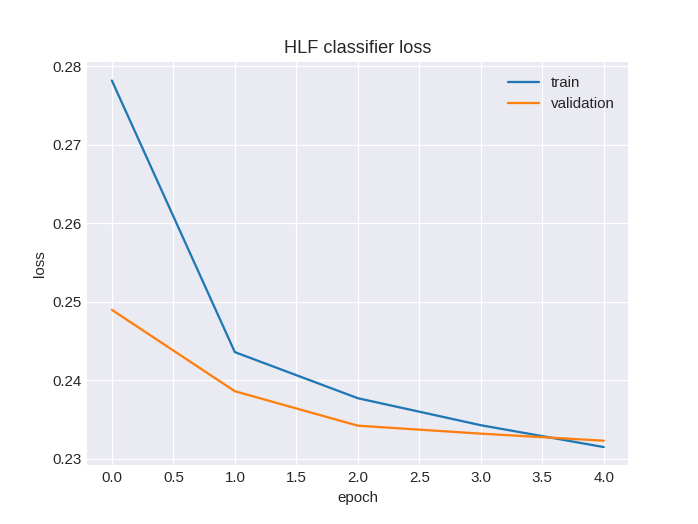

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


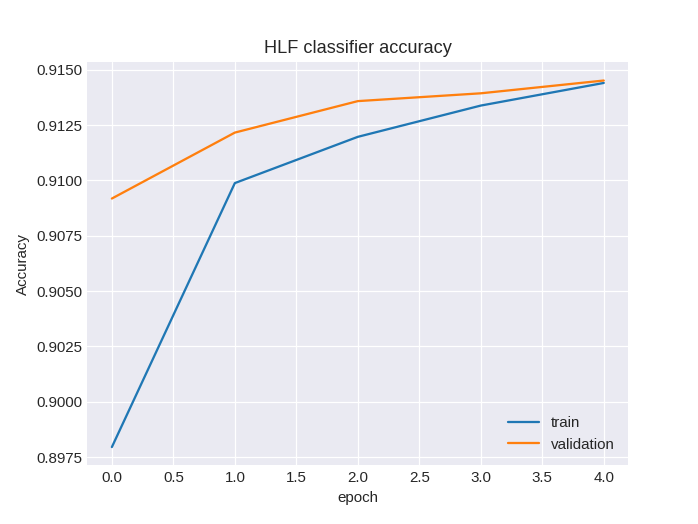

In [18]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [19]:
y_pred = history.model.predict(test)

84/84 [==============================] - 8s 87ms/step


In [20]:
# extract the labels from parsed_test_dataset
%time y_true = np.stack([labels.numpy() for features,labels in parsed_test_dataset.__iter__()])

CPU times: user 2min 57s, sys: 12.3 s, total: 3min 9s
Wall time: 2min 16s


In [21]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9145


/tmp/luca/ipykernel_30492/950292951.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1)


<IPython.core.display.Javascript object>


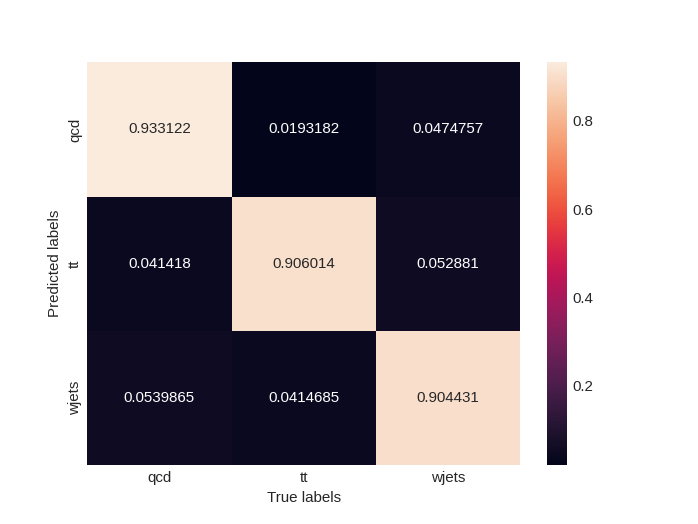

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [23]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [24]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.986974441355675, 1: 0.9848465205132008, 2: 0.980838069307209}

<IPython.core.display.Javascript object>


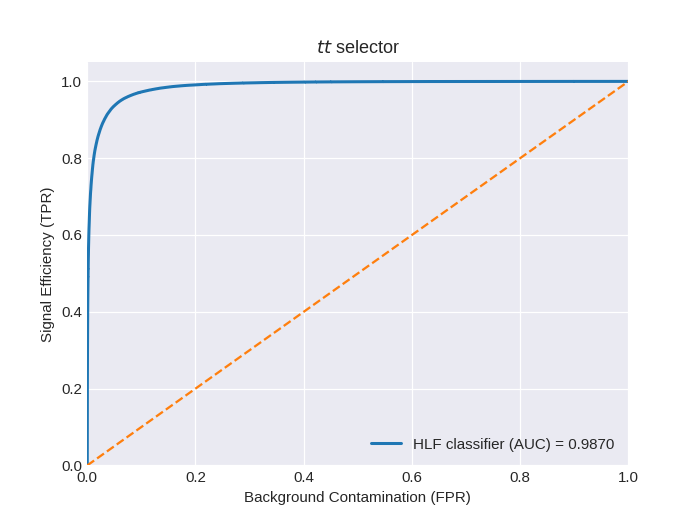

In [25]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()